# Project1 part 2: Luis solution ((e) and (d))

## Importing packages

In [1]:
from random import random, seed
from numpy import *

from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from imageio import imread

## Changeble variable 

In [2]:
# Running the fitting on the entire terrain is time consuming, in order to determine the best fitting among our models 
# (OLS, Ridge and Lasso regression). We preform the fitting over random selected patches of the terrain data.
num_patches = 4
patch_size_row = 100
patch_size_col = 100

# Lambda values used for Ridge and Lasso (can be a single value or and array with multible values). This values where picked
# from trial and error, in order to give the best performance
lambRid = [0.001, 0.01, 0.02, 0.1] 
lambLasso = [0.001, 0.01, 0.03, 0.1] 

# Number of iteration, preformed by Lasso
iterations = 10000

# Number of plits preformed on the data, for cross-validation
K = 5

## Defined function, used in "Project1 part 1"

### Vandermonde matrix function

In [3]:
def Vandermonde(x,y,order):
    '''
    Create a Vandermonde matrix from x- and y-data, which the order can be specified up too 5. order
    
      (x,y): Input variables
      order: Desired polynomial degree
    Returns: This fuction returns a matrix of (N,p), where N is the number samples and p the features.
    '''
    x = ravel(x)
    y = ravel(y)
    N = size(x)
    
    if order == 1:
        X = c_[ones((N,1)), x, y]
        
    if order == 2:
        X = c_[ones((N,1)), x, x**2, y, y**2, x*y]
        
    if order == 3:
        X = c_[ones((N,1)), x, x**2, x**3, y , y**2, y**3, x*y, x**2*y, x*y**2]
        
    if order == 4:
        X = c_[ones((N,1)), x, x**2, x**3, x**4, y, y**2, y**3, y**4, x*y, x**2*y, x*y**2, x**3*y, x**2*y**2, x*y**3]
    
    if order == 5:
        X = c_[ones((N,1)), x, x**2, x**3, x**4, x**5, y, y**2, y**3, y**4, y**5, x*y, x**2*y, x*y**2, x**3*y, x**2*y**2, \
               x*y**3,x**4*y, x**3*y**2, x**2*y**3, x*y**4]
    return X

### Regression coefficients generator

In [4]:
# Estimating the polynomial regression coefficients (using ordinary least squares estimation), with the given "data"
# and "Vandermonde matrix".
def betaOLS(data, Vandermonde_matrix):
    data = ravel(data)
    
    beta_coefficient = linalg.inv(Vandermonde_matrix.T.dot(Vandermonde_matrix)).dot(Vandermonde_matrix.T).dot(data)
    return beta_coefficient

### Ordinary Least Squares method prediction

In [5]:
# Estimating the prediction of "data" by Ordinary Least Squares method 
def PredictionOLS(data, Vandermonde_matrix, order):
    '''
    Estimating the prediction of "data" by Ordinary Least Squares method
    
    Requirements: Vandermonde matrix function (earlier defined) and OLS regression coefficients "betaOLS".
    
                  data: Data from which we want a prediction for.
    Vandermonde_matrix: In this case, a Vandermonde matrix of x and y dependence.
                 order: Here we send the order in which "Vandermonde_matrix" was fitted.
    '''
    
    # Checking if "data" is a vector or a matrix, by checking the number of output the shape() function gives
    if size(data.shape) == 1:
        [n] = data.shape
    
        # Creating a coordinate basis
        xb = linspace(0, 1, n)
        yb = linspace(0, 1, n)
        Xbmatrix = Vandermonde(xb,yb,order)
    
        beta = betaOLS(data, Vandermonde_matrix)
    
        prediction = Xbmatrix.dot(beta)        
    
    else:
        [n,m] = data.shape
    
        # Creating a coordinate basis
        xb = linspace(0, 1, n)
        yb = linspace(0, 1, m)
        xb, yb = meshgrid(xb,yb)
        Xbmatrix = Vandermonde(xb,yb,order)
    
        beta = betaOLS(data, Vandermonde_matrix)
    
        prediction = Xbmatrix.dot(beta)
        prediction = prediction.reshape((n, m))
    return prediction

### Variances of beta parameters

In [6]:
# We send in the Vandermonde matrix "X", assuming that each column corresponds to a dimention/feature
def beta_variance(data, prediction, X):
    N = len(X)    # Extracting the number of samples 
    p = len(X[0]) # Extracting the number of features
    
    sigma2 = 1/(N - p - 1)*sum((data - prediction)**2)
    estimation = linalg.inv(X.T.dot(X))*sigma2
    return estimation.diagonal()

### Standard definition: Mean Squared Error, Bias, R2 score and my own variance

In [7]:
# Defined estimate function of mean squared error
def mse(data, prediction):
    data = data.ravel()
    prediction = prediction.ravel()
    
    L = size(data) # Total number of data points
    estimate = sum((data - prediction)**2)/L
    return estimate

# Defined estimate function of bias
def bias(data, prediction):
    data = data.ravel()
    prediction = prediction.ravel()
    
    L = size(data) # Total number of data points
    estimate = sum((data - mean(prediction))**2)/L
    return estimate

# Just my home brew variance
def my_var(data):
    data = data.ravel()
    
    L = size(data) # Total number of data points
    estimate = sum((data - data.mean())**2)/L
    return estimate

# Defined estimate function of R2 score
def R2(data, prediction):
    data = data.ravel()
    prediction = prediction.ravel()

    estimate = 1 - sum((data - prediction)**2)/sum((data - data.mean())**2)
    return estimate

### Resampling methods: K-fold cross-validation

In [8]:
def Kfold_train_test_split(data, K):
    '''
    Return: This function returns two lists, the first list contains the arrays of "train data set" 
            and the second list contains the arrays of "test data set".
    
    data: Data in which wwe wish to split into training and test segments
       K: Desired number of splits/folds
    '''
    
    data = data.ravel()

    L = size(data)  # Extracting the total number of samples.
    M = ceil(L/K)   # The number of samples in one fold/segment, this might not be true on the last fold.

    data_train = []
    data_test = []
    for k in range(0, K):
        Start_fold = int(M*k)     # Starting point for fold number k 
        End_fold = int(M*k + M)   # Ending point for fold number k
        
        #print("Starting point for %d segment:" % (k+1) , Start_fold)
        #print("Ending point for the %d. segment:" % (k+1) , End_fold)
    
        if End_fold <= L:
            data_test.append( data[Start_fold:End_fold] )
    
        # If the end point is greater then the length of Xn, then save
        # the remaining values of "data" on data_train. This will cause the last fold to be shorter.
        elif End_fold > L:
            End_fold = int(L)
            data_test.append( data[Start_fold:End_fold] )
        
        if k == 0:
            data_train.append( data[End_fold:L] )
        
        if k > 0 and k < K-1:
            data_train.append( concatenate((data[0:Start_fold], data[End_fold:L])) )
        
        if k == K-1:
            data_train.append( data[0:Start_fold] )
        
    # Printing the number of elements in training and test set
    #print("No. of elements in training set: %.2f" % shape(data_train[0]))
    #print("No. of elements in the last training set: %.2f" % shape(data_train[K-1]))
    #print("No. of elements in test set: %.2f" % shape(data_test[0]))
    #print("No. of elements in the last test set: %.2f" % shape(data_test[K-1]))
    return data_train , data_test

### OLS method: Mean Square Error and R2 score of training- and test-sets (implemented with K-fold cross validation in mind)

In [9]:
# Defining a function that estimates the MSE of OLS cross validation of given array sets (in 3 dimentions "x,y,z")
# It takes in lists containing the splited arrays of xyz, and the number of folds.
def mseOLS_cv(X_set, Y_set, Z_set, fold_num, order):
    '''
    Requires: Vandermonde matrix function, PredictionOLS fuction and Mean Squared Error function "mse".
     Returns: Here we return an array containing the Mean Squared Error for each fold.
    
       X_set: A list containing the folded/splited arrays corresponding to the x-coordinate.
       Y_set: A list containing the folded/splited arrays corresponding to the y-coordinate.
       Z_set: A list containing the folded/splited arrays corresponding to the z-coordinate.
    fold_num: Number of folds/splits.
       order: Here we send the order in which "Vandermonde_matrix" was fitted.
    '''
    
    K = fold_num
    
    mse_array = zeros(K)
    for i in range(0,K):
        Xmatrix = Vandermonde(X_set[i], Y_set[i], order)
        Zpredic= PredictionOLS(Z_set[i], Xmatrix, order)
    
        mse_array[i] = round(mse(Z_set[i],Zpredic),3) # Mean Square error: save estimates in a array
    return mse_array

def R2OLS_cv(X_set, Y_set, Z_set, fold_num, order):
    '''
    Requires: Vandermonde matrix function, PredictionOLS fuction and R2 score function "R2".
     Returns: Here we return an array containing the R2 score for each fold.
    
       X_set: A list containing the folded/splited arrays corresponding to the x-coordinate.
       Y_set: A list containing the folded/splited arrays corresponding to the y-coordinate.
       Z_set: A list containing the folded/splited arrays corresponding to the z-coordinate.
    fold_num: Number of folds/splits.
       order: Here we send the order in which "Vandermonde_matrix" was fitted.
    '''
    
    K = fold_num
    
    R2_array = zeros(K)
    for i in range(0,K):
        Xmatrix = Vandermonde(X_set[i], Y_set[i], order)
        Zpredic= PredictionOLS(Z_set[i], Xmatrix, order)
    
        R2_array[i] = round(R2(Z_set[i],Zpredic),3) # R2 score: save estimates in a array
    
    return R2_array

### Estimating the polynomial regression coefficients for the Ridge method

In [10]:
# Here we estimate the Ridge regression coefficients, where X is the Vandermonde_matrix and "lamb" the lambda/alpha values
def betaRidge(data, X, lamb):
    '''
    Returns: The return depends on the parameter "lamb". If "lamb" is a single value, the function returns the 
             estimated coefficients for that given value. If "lamb" is an row/column vector containing multiple values,
             then this function returns a list containing the estimated coefficients for each value in "lamb", in the
             respective order.  
    
    data: Data in which want to estimate the coefficients for.
       X: Vandermonde matrix.
    lamb: lambda/alpha values. Remember, this is Ridge regression.
    '''
    
    data = data.ravel()
    N = len(X[0])
    
    if size(lamb) > 1:
        estimate = []
        for i in range(0,size(lamb)):
            estimate.append(linalg.inv(X.T.dot(X) + lamb[i]*identity(N)).dot(X.T).dot(data))
    else:
        estimate = linalg.inv(X.T.dot(X) + lamb*identity(N)).dot(X.T).dot(data)
    return estimate

### Ridge regression method prediction

In [11]:
# Estimating the prediction of "data" by Ridge method 
def PredictionRid(data, Vandermonde_matrix, order, lamb):
    '''
    Requires: Vandermonde matrix function.
     Returns: The return depends on the parameter "lamb". If "lamb" is a single value, the function returns the 
              prediction for that given value. If "lamb" is an row/column vector containing multiple values, then this
              function returns a list containing the predictions for each value in "lamb", in it's respective order.
    
                  data: Data from which we want a prediction for.
    Vandermonde_matrix: In this case, a Vandermonde matrix of x and y dependence.
                 order: Here we send the order in which "Vandermonde_matrix" was fitted.
                  lamb: lambda/alpha value.
    '''
    
    # Checking if "data" is a vector or a matrix, by checking the number of output the shape() function gives
    if size(data.shape) == 1:
        [n] = data.shape
    
        # Creating a coordinate basis
        xb = linspace(0, 1, n)
        yb = linspace(0, 1, n)
        Xbmatrix = Vandermonde(xb,yb,order)
    
        beta = betaRidge(data, Vandermonde_matrix, lamb)
    
        # Creating predictions, depending on how many lambda values there are.
        if size(lamb) > 1:
            prediction = []
            for i in range(0,size(lamb)):
                prediction.append(Xbmatrix.dot(beta[i]))
        else:
            prediction = Xbmatrix.dot(beta)      
    
    else:
        [n,m] = data.shape
    
        # Creating a coordinate basis
        xb = linspace(0, 1, n)
        yb = linspace(0, 1, m)
        xb, yb = meshgrid(xb,yb)
        Xbmatrix = Vandermonde(xb,yb,order)
    
        beta = betaRidge(data, Vandermonde_matrix, lamb)
    
        # Creating predictions, depending on how many lambda values there are.
        if size(lamb) > 1:
            prediction = []
            for i in range(0,size(lamb)):
                temp = Xbmatrix.dot(beta[i])
                prediction.append(temp.reshape((n, m)))
        else:
            prediction = Xbmatrix.dot(beta)
            prediction = prediction.reshape((n, m))
        
    return prediction

### Ridge method: Mean Square Error and R2 score of training- and test-sets (implemented with K-fold cross validation in mind)

In [12]:
# More or less identical to MSE and R2 score for OLS, with the exection that we now use Ridge prediction values and we feed
# the defined function a single lambda/alpha value
def mseRid_cv(X_set, Y_set, Z_set, fold_num, order, lamb):
    '''
    Requires: Vandermonde matrix function, PredictionRid fuction and Mean Squared Error function "mse".
     Returns: Here we return an array containing the Mean Squared Error for each fold.
    
       X_set: A list containing the folded/splited arrays corresponding to the x-coordinate.
       Y_set: A list containing the folded/splited arrays corresponding to the y-coordinate.
       Z_set: A list containing the folded/splited arrays corresponding to the z-coordinate.
    fold_num: Number of folds/splits.
       order: Here we send the order in which "Vandermonde_matrix" was fitted.
        lamb: Lambda/alpha value (send in, only one value).
    '''
    
    if size(lamb) > 1:
        print("Please sir, may I have only one lamb. (send only one lambda value)")
        
    
    K = fold_num
    
    mse_array = zeros(K)
    for i in range(0,K):
        Xmatrix = Vandermonde(X_set[i], Y_set[i], order)
        Zpredic= PredictionRid(Z_set[i], Xmatrix, order, lamb)
    
        mse_array[i] = round(mse(Z_set[i],Zpredic),3) # Mean Square error: save estimates in a array
    return mse_array

def R2Rid_cv(X_set, Y_set, Z_set, fold_num, order, lamb):
    '''
    Requires: Vandermonde matrix function, PredictionRid fuction and R2 score function "R2".
     Returns: Here we return an array containing the R2 score for each fold.
    
       X_set: A list containing the folded/splited arrays corresponding to the x-coordinate.
       Y_set: A list containing the folded/splited arrays corresponding to the y-coordinate.
       Z_set: A list containing the folded/splited arrays corresponding to the z-coordinate.
    fold_num: Number of folds/splits.
       order: Here we send the order in which "Vandermonde_matrix" was fitted.
        lamb: Lambda/alpha value (send in, only one value).
    '''
    
    if size(lamb) > 1:
        print("Please sir, may I have only one lamb. (send only one lambda value)")
    
    K = fold_num
    
    R2_array = zeros(K)
    for i in range(0,K):
        Xmatrix = Vandermonde(X_set[i], Y_set[i], order)
        Zpredic= PredictionRid(Z_set[i], Xmatrix, order, lamb)
    
        R2_array[i] = round(R2(Z_set[i],Zpredic),3) # R2 score: save estimates in a array
    
    return R2_array

## Part d) Introducing real data

### Surface plot function (this function was kindly provided by Kristine, so I here by clarify that this function is not home brewed, but it is slightly modified)

In [13]:
def surface_plot(surface, titl, surface2=None, titl2=None):    
    M,N = surface.shape

    ax_rows = linspace(0,1,M)
    ax_cols = linspace(0,1,N)

    [X,Y] = meshgrid(ax_cols, ax_rows)

    fig = figure()
    if surface2 is not None:
        ax = fig.add_subplot(1,2,1,projection='3d')
        ax.plot_surface(X,Y,surface,cmap=cm.viridis,linewidth=0)
        xlabel('X axis')
        ylabel('Y axis')
        title(titl)

        ax = fig.add_subplot(1,2,2,projection='3d')
        ax.plot_surface(X,Y,surface2,cmap=cm.viridis,linewidth=0)
        xlabel('X axis')
        ylabel('Y axis')
        title(titl2)
    
    else:
        ax = fig.gca(projection='3d')
        ax.plot_surface(X,Y,surface,cmap=cm.viridis,linewidth=0)
        xlabel('X axis')
        ylabel('Y axis')
        title(titl)

c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\imageio\plugins\_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'r

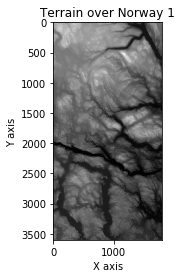

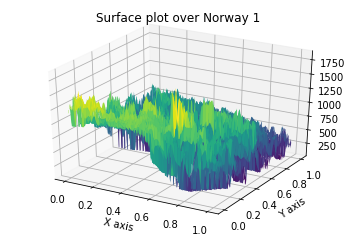

In [14]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
fig = figure()
imshow(terrain1, cmap='gray')
title('Terrain over Norway 1')
xlabel('X axis')
ylabel('Y axis')

surface_plot(terrain1, 'Surface plot over Norway 1')

## Part e) OLS, Ridge and Lasso regression with resampling

#### Preforming a fit over the entire terrain data is computational heavy, hence it is better to preform it on a segment/patch of the data.

In [15]:
# Extracting the row and column sizes
[n,m] = terrain1.shape

## Find some random patches within the dataset and perform a fit
# Define their axes
rows = linspace(0,1,patch_size_row)
cols = linspace(0,1,patch_size_col)
[x,y] = meshgrid(cols,rows)

# Creating Vandermonde matrices from 1. to 5.order
i = 0
Vander_num = 5
Xmatrix = []
for i in range(0,Vander_num):
    Xmatrix.append(Vandermonde(x,y,i+1))

# Find the start indices of each patch
random.seed(15)
row_starts = random.randint(0,n-patch_size_row,num_patches)
col_starts = random.randint(0,m-patch_size_col,num_patches)    

#### Now that all the preparation are done (loading and patching), we proceed by estimating the OLS, Ridge, Lasso prediction for all the patches

In [16]:
i = 0
z_patch = []
ZpredicOLS = []
ZpredicRid = []
ZpredicLasso = []
Lasso_coef_used = []
for i,row_start, col_start in zip(np.arange(num_patches),row_starts, col_starts):
    row_end = row_start + patch_size_row
    col_end = col_start + patch_size_col
    
    z_patch.append(terrain1[row_start:row_end, col_start:col_end]) # save terrain patch as an array for later
    
    [n,m] = z_patch[i].shape
    
    ## Estimating the OLS prediction for 3., 4. and 5. order polynomial approximation
    j = 0
    for j in range(0,Vander_num):
        ZpredicOLS.append(PredictionOLS(z_patch[i], Xmatrix[j], j+1))
        
    
    ## Estimating the Ridge prediction for the following lambda values (5.order polynomial approximation)
    order = 5
    ZpredicRid.append(PredictionRid(z_patch[i], Xmatrix[Vander_num-1], order, lambRid))
    
    ## Estimating the Lasso prediction for the following lambda values (5.order polynomial approximation)
    j = 0
    for j in range(0,size(lambLasso)):
        lasso = Lasso(lambLasso[j], max_iter=iterations).fit(Xmatrix[Vander_num-1], z_patch[i].ravel())
        
        temp = lasso.predict(Xmatrix[Vander_num-1])
        ZpredicLasso.append(temp.reshape((n, m)))
        
        Lasso_coef_used.append(sum(lasso.coef_ != 0)) # saving the number of features used for each lambda value

c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### Some general plotting

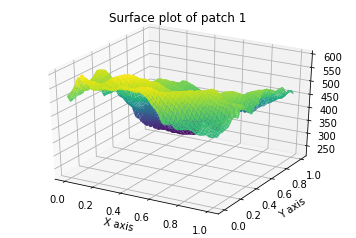

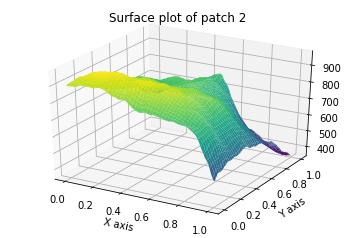

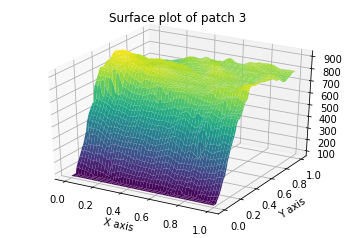

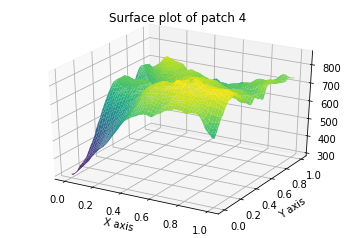

In [17]:
# Plotting of the different patches
i = 0
for i in range(0,num_patches):
    surface_plot(z_patch[i], "Surface plot of patch %d" % (i+1))

In [18]:
print("OLS prediction list shape:" , shape(array(ZpredicOLS)))
print("Ridge prediction list shape:" , shape(array(ZpredicRid)))
print("Lasso prediction list shape:" , shape(array(ZpredicLasso)))
print("Lasso coefficients list shape:" , shape(Lasso_coef_used))

OLS prediction list shape: (20, 100, 100)
Ridge prediction list shape: (4, 4, 100, 100)
Lasso prediction list shape: (16, 100, 100)
Lasso coefficients list shape: (16,)


#### OLS prediction plot

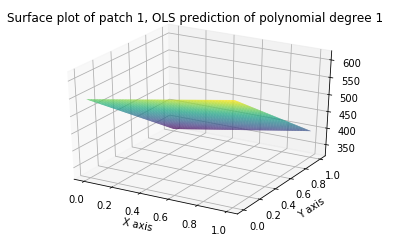

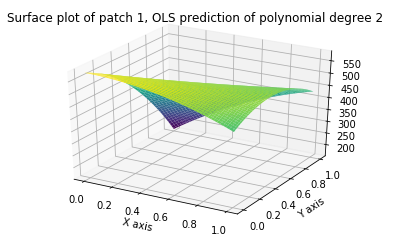

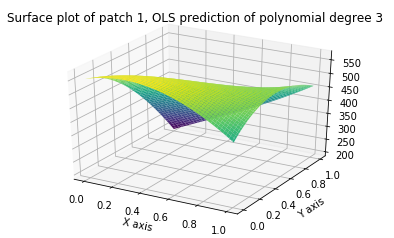

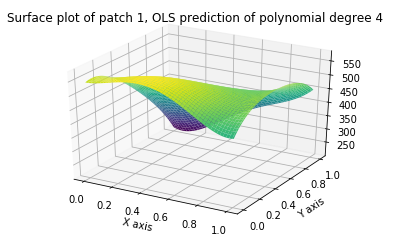

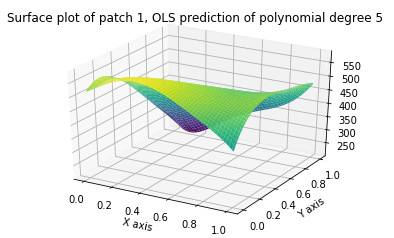

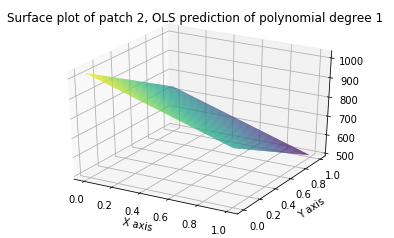

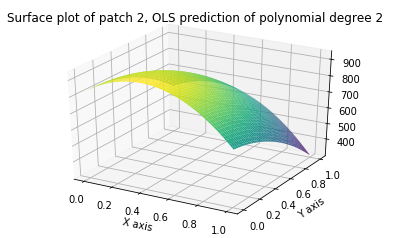

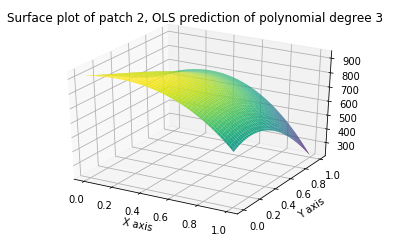

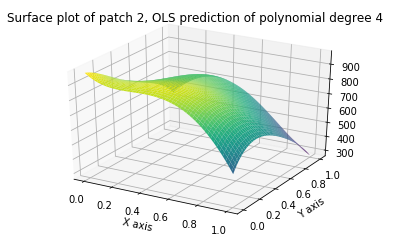

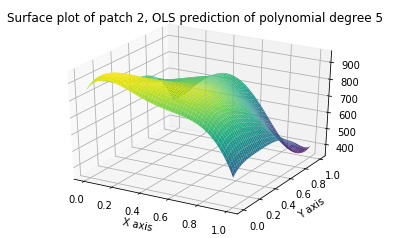

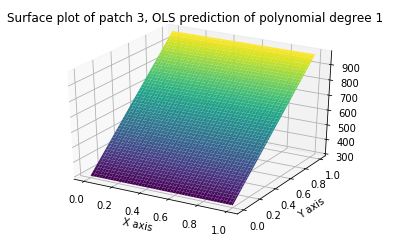

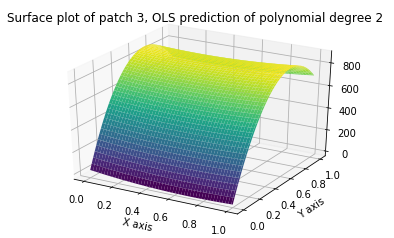

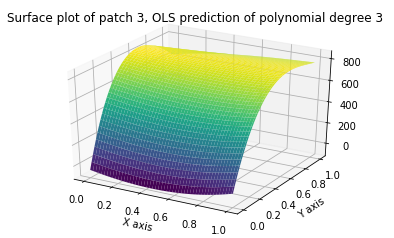

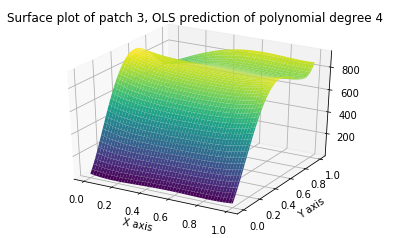

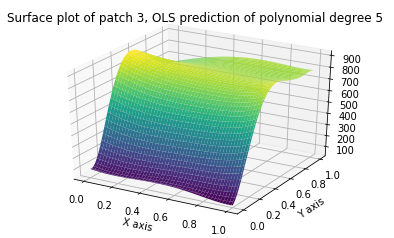

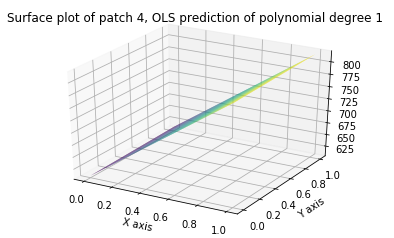

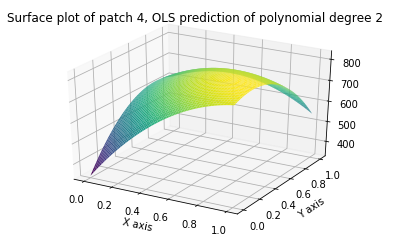

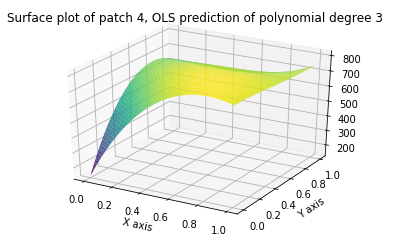

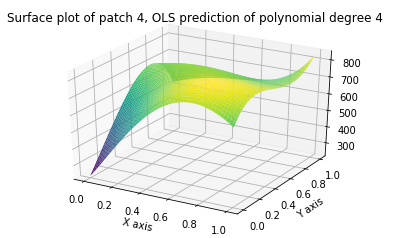

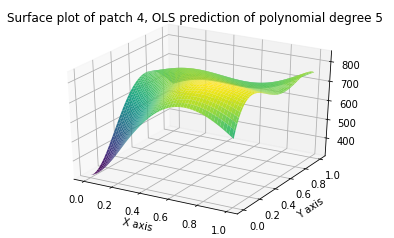

In [19]:
i = 0
for i in range(0,num_patches):
    j = 0
    for j in range(0,Vander_num):
        surface_plot(ZpredicOLS[(i*Vander_num + j)], "Surface plot of patch %d, OLS prediction of polynomial degree %d " % ((i+1), (j+1)))

#### Ridge prediction plot

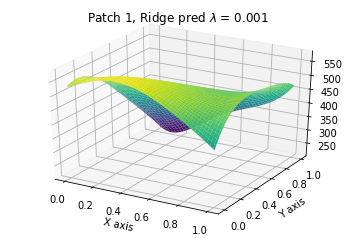

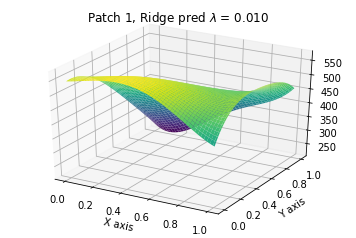

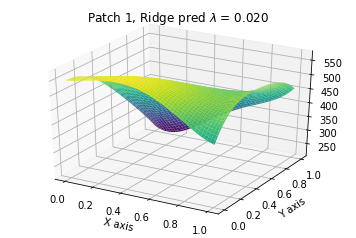

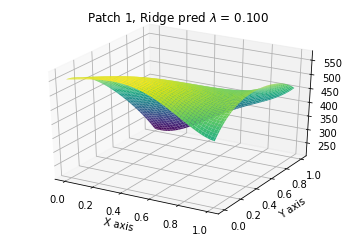

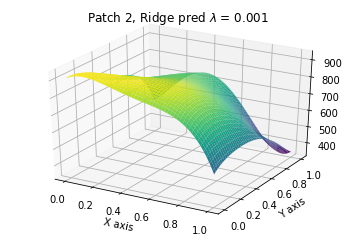

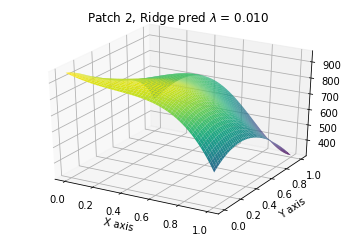

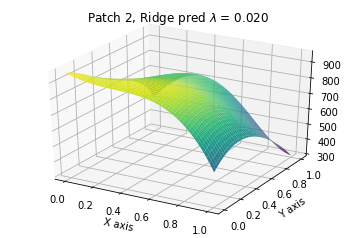

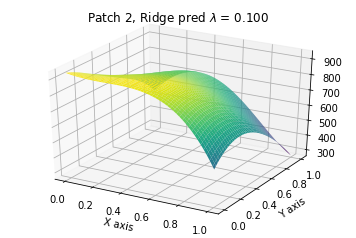

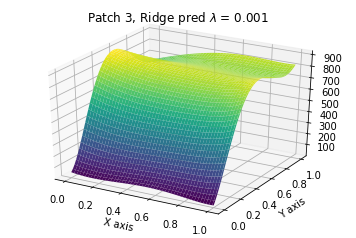

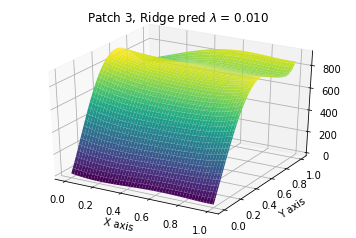

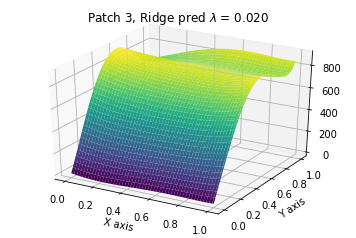

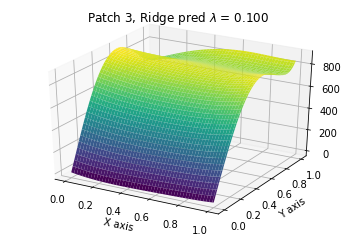

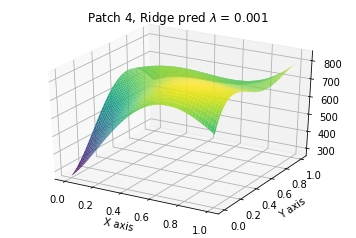

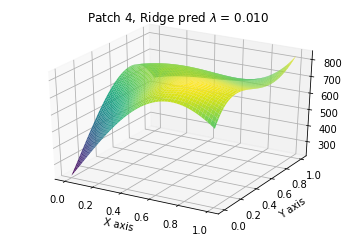

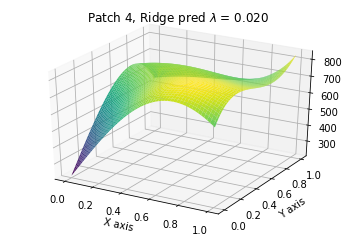

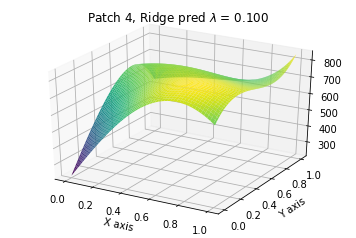

In [20]:
i = 0
for i in range(0,num_patches):
    j = 0
    for j in range(0,size(lambRid)):
        surface_plot(ZpredicRid[i][j], "Patch %d, Ridge pred $\lambda$ = %.3f" % ((i+1), (lambRid[j])))

#### Lasso prediction plot

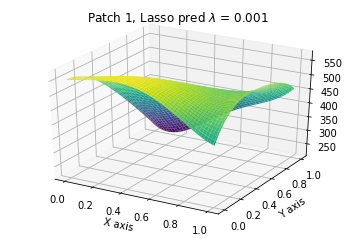

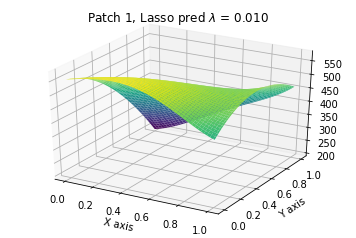

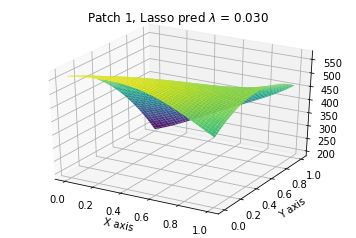

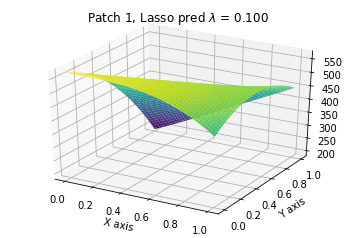

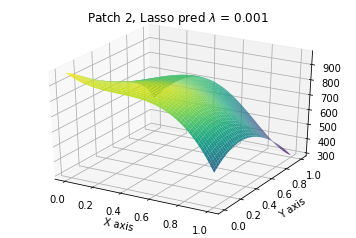

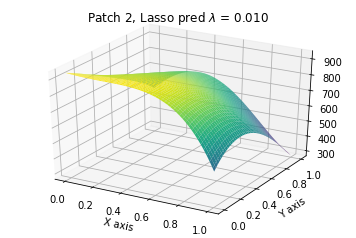

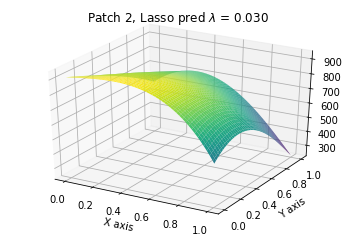

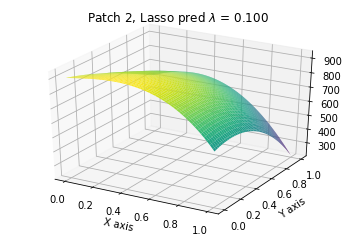

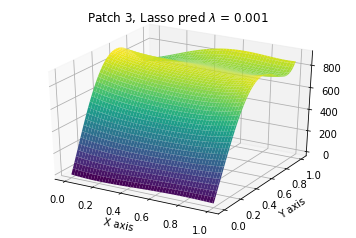

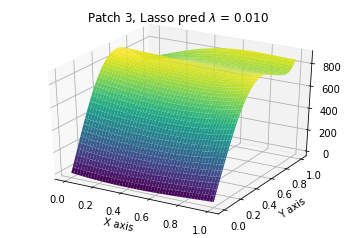

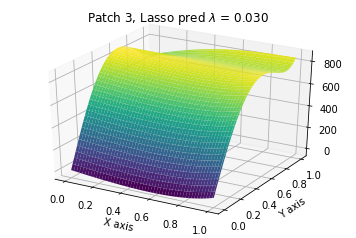

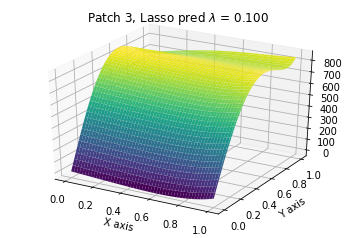

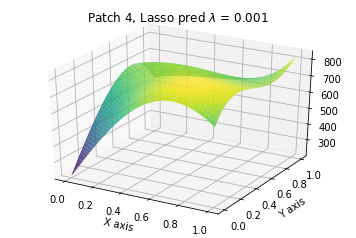

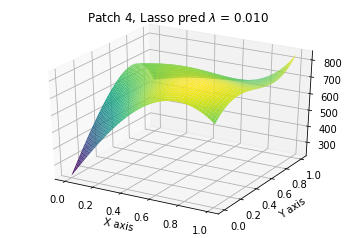

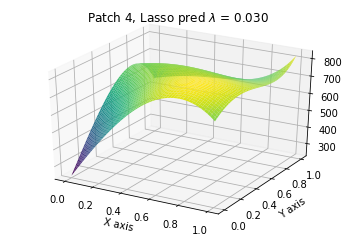

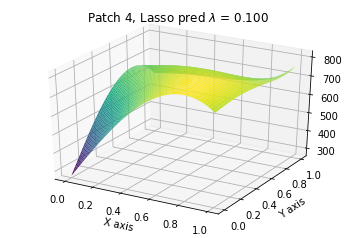

In [21]:
i = 0
for i in range(0,num_patches):
    j = 0
    for j in range(0,size(lambLasso)):
        surface_plot(ZpredicLasso[(i*size(lambLasso) + j)], ("Patch %d, Lasso pred $\lambda$ = %.3f" % ((i+1),lambLasso[j])))

#### Estimating the Beta variance, Mean Squared error, Bias, prediction variance and R^2 score

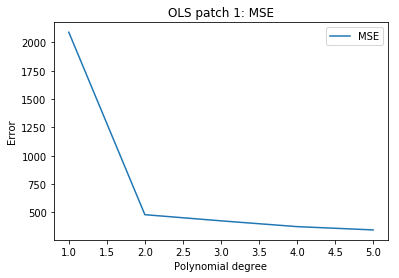

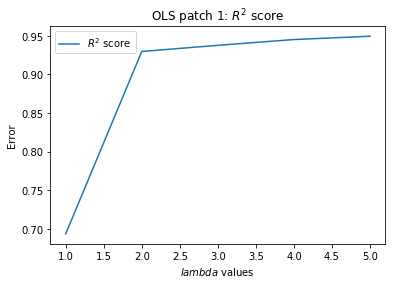

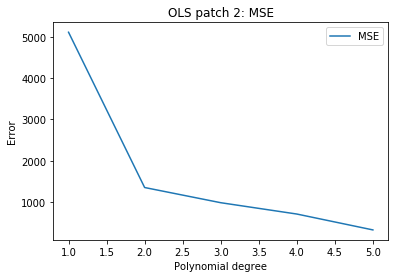

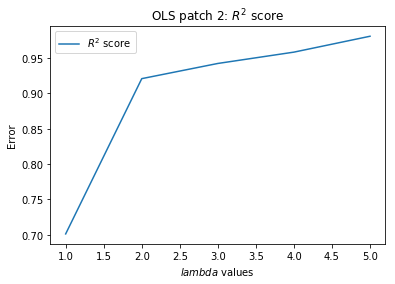

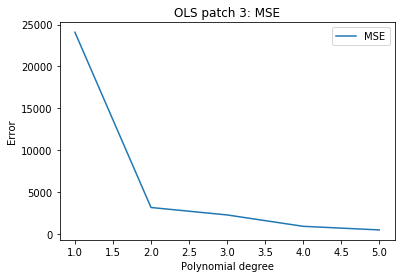

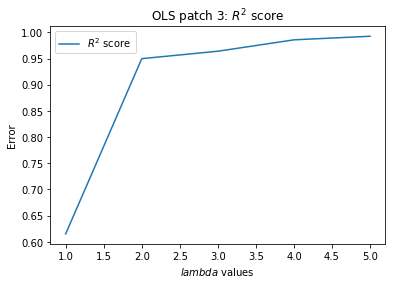

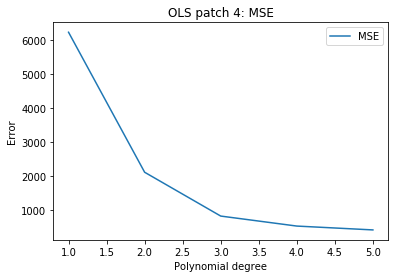

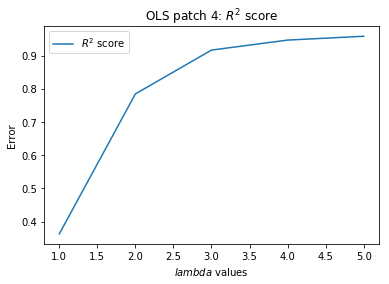

In [22]:
# Bias-Variance tradeoff plot
i = 0
for i in range(0,num_patches):
    
    # Estimate the MSE, Bias and prediction variance for each corresponding polynomial fit
    j = 0
    array_OLS_MSE = zeros(Vander_num)
    array_OLS_Bias = zeros(Vander_num)
    array_OLS_Var = zeros(Vander_num)
    array_OLS_Noise = zeros(Vander_num)
    array_OLS_R2 = zeros(Vander_num)
    for j in range(0,Vander_num):
        array_OLS_MSE[j] = mse(z_patch[i], ZpredicOLS[(i*Vander_num + j)])
        array_OLS_Bias[j] = bias(z_patch[i], ZpredicOLS[(i*Vander_num + j)])
        array_OLS_Var[j] = my_var(ZpredicOLS[(i*Vander_num + j)])
        array_OLS_Noise[j] = my_var(z_patch[i])
        array_OLS_R2[j] = R2(z_patch[i], ZpredicOLS[(i*Vander_num + j)])

    plot(linspace(1,5,Vander_num), array_OLS_MSE, label='MSE')
    
    ## Bias, prediction variance and noise don't work properly, since they are higher than MSE
    #plot(linspace(1,5,Vander_num), array_OLS_Bias, label='Bias^2')
    #plot(linspace(1,5,Vander_num), array_OLS_Var, label='Prediction var')
    #plot(linspace(1,5,Vander_num), array_OLS_Noise , '--', label='patch noise')
    xlabel("Polynomial degree")
    ylabel("Error")
    title("OLS patch %d: MSE" % (i+1))
    legend()
    show()
    
    plot(linspace(1,5,Vander_num), array_OLS_R2, label='$R^2$ score')
    xlabel("$lambda$ values")
    ylabel("Error")
    title("OLS patch %d: $R^2$ score" % (i+1))
    legend()
    show()

In [23]:
print ("Ordinary Least Squares method:")
print ("-------------------------------")

i = 0
for i in range(0,num_patches):
    print("patch %d:" % (i+1))

    j = 0
    for j in range(0,Vander_num):
        print("Estimated variance of beta parameters for the %d.order polynomial:" % (j+1))
        print(beta_variance(z_patch[i], ZpredicOLS[(i*Vander_num + j)], Xmatrix[j]))
    
    j = 0
    array_OLS_MSE = zeros(Vander_num)
    array_OLS_Bias = zeros(Vander_num)
    array_OLS_Var = zeros(Vander_num)
    array_OLS_R2 = zeros(Vander_num)
    for j in range(0,Vander_num):
        array_OLS_MSE[j] = round(mse(z_patch[i], ZpredicOLS[(i*Vander_num + j)]),2)
        array_OLS_Bias[j] = round(bias(z_patch[i], ZpredicOLS[(i*Vander_num + j)]),2)
        array_OLS_Var[j] = round(my_var(ZpredicOLS[(i*Vander_num + j)]),2)
        array_OLS_R2[j] = round(R2(z_patch[i],ZpredicOLS[(i*Vander_num + j)]),2)
    
    
    print("The OLS mean squared error:" , array_OLS_MSE)
    print("The OLS Bias:" , array_OLS_Bias)
    print("Variance of the OLS predictor:" , array_OLS_Var)
    print('The OLS R2 score:' , array_OLS_R2)
    print("-------------------------------------------------------------------------------------------------")


Ordinary Least Squares method:
-------------------------------
patch 1:
Estimated variance of beta parameters for the 1.order polynomial:
[1.43906554 2.45987031 2.45987031]
Estimated variance of beta parameters for the 2.order polynomial:
[ 1.19566564 10.51327153  8.29166136 10.51327153  8.29166136  6.63133889]
Estimated variance of beta parameters for the 3.order polynomial:
[  2.76574446  73.3045143  281.49577474 112.22863843  73.3045143
 281.49577474 112.22863843 178.89610368  86.50711019  86.50711019]
Estimated variance of beta parameters for the 4.order polynomial:
[5.18091803e+00 3.22199525e+02 3.43929664e+03 6.49739871e+03
 1.52705059e+03 3.22199525e+02 3.43929664e+03 6.49739871e+03
 1.52705059e+03 2.10517612e+03 3.80967514e+03 3.80967514e+03
 1.16172174e+03 1.11967134e+03 1.16172174e+03]
Estimated variance of beta parameters for the 5.order polynomial:
[8.85674901e+00 1.11127244e+03 2.59102491e+04 1.30753285e+05
 1.42602457e+05 2.19280730e+04 1.11127244e+03 2.59102491e+04
 1.30

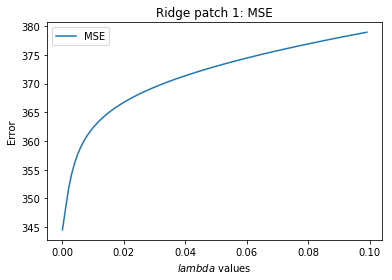

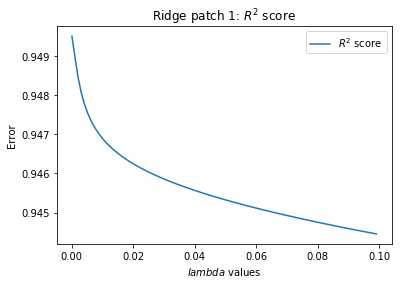

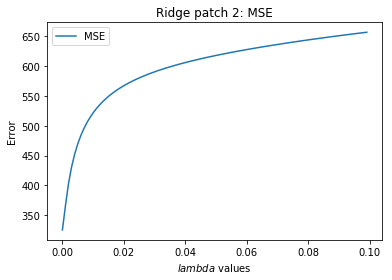

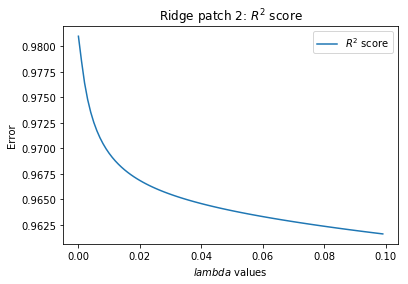

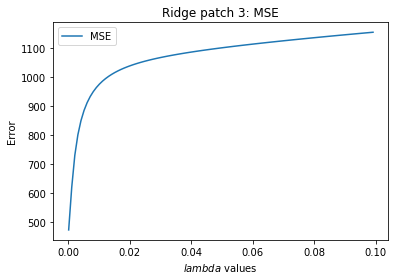

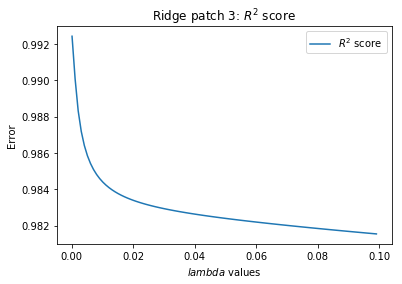

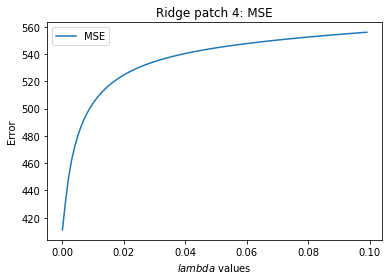

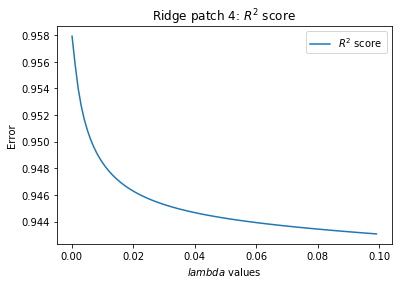

In [24]:
alphasRid = arange(0.0001,0.1, 0.001)

# Bias-Variance tradeoff plot
i = 0
ZpredicRid_temp = []
for i in range(0,num_patches):
    
    # Estimating the Ridge predictions for all lambda/alpha values in alphasRid, with 5. degree polynomial fit
    ZpredicRid_temp.append(PredictionRid(z_patch[i], Xmatrix[Vander_num-1], order, alphasRid))
    
    # Estimate the MSE, Bias and prediction variance for each corresponding lambda/alpha value fit
    j = 0
    array_Rid_MSE = zeros(size(alphasRid))
    array_Rid_Bias = zeros(size(alphasRid))
    array_Rid_Var = zeros(size(alphasRid))
    array_Rid_R2 = zeros(size(alphasRid))
    for j in range(0,size(alphasRid)):
        array_Rid_MSE[j] = mse(z_patch[i], ZpredicRid_temp[i][j])
        array_Rid_Bias[j] = bias(z_patch[i], ZpredicRid_temp[i][j])
        array_Rid_Var[j] = my_var(ZpredicRid_temp[i][j])
        array_Rid_R2[j] = R2(z_patch[i], ZpredicRid_temp[i][j])
        
    plot(alphasRid, array_Rid_MSE, label='MSE')
    
    ## Bias and prediction variance don't work properly
    #plot(alphasRid, array_Rid_Bias, label='Bias^2')
    #plot(alphasRid, array_Rid_Var, label='Prediction var')
    xlabel("$lambda$ values")
    ylabel("Error")
    title("Ridge patch %d: MSE" % (i+1))
    legend()
    show()
    
    plot(alphasRid, array_Rid_R2, label='$R^2$ score')
    xlabel("$lambda$ values")
    ylabel("Error")
    title("Ridge patch %d: $R^2$ score" % (i+1))
    legend()
    show()

In [25]:
print ("Ridge regression method:")
print ("-------------------------")
print("The Ridge lambda/alpha values:" , lambRid)

i = 0
for i in range(0,num_patches):
    print("patch %d:" % (i+1))

    j = 0
    for j in range(0,size(lambRid)):
        print("Estimated variance of beta parameters for the lambda value:" , lambRid[j])
        print(beta_variance(z_patch[i], ZpredicRid[i][j], Xmatrix[Vander_num-1]))
    
    j = 0
    array_Rid_MSE = zeros(size(lambRid))
    array_Rid_Bias = zeros(size(lambRid))
    array_Rid_Var = zeros(size(lambRid))
    array_Rid_R2 = zeros(size(lambRid))
    for j in range(0,size(lambRid)):
        array_Rid_MSE[j] = round(mse(z_patch[i], ZpredicRid[i][j]),2)
        array_Rid_Bias[j] = round(bias(z_patch[i], ZpredicRid[i][j]),2)
        array_Rid_Var[j] = round(my_var(ZpredicRid[i][j]),2)
        array_Rid_R2[j] = round(R2(z_patch[i],ZpredicRid[i][j]),2)
    
    
    print("The Ridge mean squared error:" , array_Rid_MSE)
    print("The Ridge Bias:" , array_Rid_Bias)
    print("Variance of the Ridge predictor:" , array_Rid_Var)
    print('The Ridge R2 score:' , array_Rid_R2)
    print("-------------------------------------------------------------------------------------------------")

Ridge regression method:
-------------------------
The Ridge lambda/alpha values: [0.001, 0.01, 0.02, 0.1]
patch 1:
Estimated variance of beta parameters for the lambda value: 0.001
[8.94228048e+00 1.12200423e+03 2.61604697e+04 1.32015996e+05
 1.43979598e+05 2.21398370e+04 1.12200423e+03 2.61604697e+04
 1.32015996e+05 1.43979598e+05 2.21398369e+04 1.59572622e+04
 7.25102470e+04 7.25102470e+04 8.39280260e+04 7.26670006e+04
 8.39280260e+04 1.67323455e+04 1.59164368e+04 1.59164368e+04
 1.67323455e+04]
Estimated variance of beta parameters for the lambda value: 0.01
[9.31550998e+00 1.16883402e+03 2.72523455e+04 1.37526030e+05
 1.49988964e+05 2.30639011e+04 1.16883402e+03 2.72523455e+04
 1.37526029e+05 1.49988964e+05 2.30639010e+04 1.66232804e+04
 7.55366521e+04 7.55366521e+04 8.74309821e+04 7.56999483e+04
 8.74309820e+04 1.74307138e+04 1.65807510e+04 1.65807510e+04
 1.74307138e+04]
Estimated variance of beta parameters for the lambda value: 0.02
[9.42941464e+00 1.18312584e+03 2.75855714e+0

In [26]:
print ("Lasso regression method:")
print ("-------------------------")
print("The Lasso lambda/alpha values:" , lambLasso)

i = 0
for i in range(0,num_patches):
    print("patch %d:" % (i+1))

    j = 0
    for j in range(0,size(lambLasso)):
        print("Estimated variance of beta parameters for the lambda value:" , lambLasso[j])
        print(beta_variance(z_patch[i], ZpredicLasso[(i*size(lambLasso) + j)], Xmatrix[Vander_num-1]))
    
    j = 0
    array_Lasso_MSE = zeros(size(lambLasso))
    array_Lasso_Bias = zeros(size(lambLasso))
    array_Lasso_Var = zeros(size(lambLasso))
    array_Lasso_R2 = zeros(size(lambLasso))
    for j in range(0,size(lambLasso)):
        array_Lasso_MSE[j] = round(mse(z_patch[i], ZpredicLasso[(i*size(lambLasso) + j)]),2)
        array_Lasso_Bias[j] = round(bias(z_patch[i], ZpredicLasso[(i*size(lambLasso) + j)]),2)
        array_Lasso_Var[j] = round(my_var(ZpredicLasso[(i*size(lambLasso) + j)]),2)
        array_Lasso_R2[j] = round(R2(z_patch[i],ZpredicLasso[(i*size(lambLasso) + j)]),2)
    
    print("Number of features used for each corresponding lambda value:" , Lasso_coef_used[i*size(lambLasso):(i+1)*size(lambLasso)])
    print("The Lasso mean squared error:" , array_Lasso_MSE)
    print("The Lasso Bias:" , array_Lasso_Bias)
    print("Variance of the Lasso predictor:" , array_Lasso_Var)
    print('The Lasso R2 score:' , array_Lasso_R2)
    print("-------------------------------------------------------------------------------------------------")

Lasso regression method:
-------------------------
The Lasso lambda/alpha values: [0.001, 0.01, 0.03, 0.1]
patch 1:
Estimated variance of beta parameters for the lambda value: 0.001
[9.44676143e+00 1.18530237e+03 2.76363191e+04 1.39463711e+05
 1.52102243e+05 2.33888613e+04 1.18530237e+03 2.76363191e+04
 1.39463711e+05 1.52102243e+05 2.33888613e+04 1.68574951e+04
 7.66009305e+04 7.66009304e+04 8.86628463e+04 7.67665274e+04
 8.86628463e+04 1.76763049e+04 1.68143665e+04 1.68143665e+04
 1.76763049e+04]
Estimated variance of beta parameters for the lambda value: 0.01
[1.02707360e+01 1.28868797e+03 3.00468410e+04 1.51628150e+05
 1.65369053e+05 2.54289073e+04 1.28868797e+03 3.00468409e+04
 1.51628150e+05 1.65369052e+05 2.54289073e+04 1.83278559e+04
 8.32822913e+04 8.32822912e+04 9.63962832e+04 8.34623320e+04
 9.63962832e+04 1.92180847e+04 1.82809655e+04 1.82809655e+04
 1.92180847e+04]
Estimated variance of beta parameters for the lambda value: 0.03
[1.07055217e+01 1.34324132e+03 3.13187980e+0

#### Now we preforme the fittings with K-fold cross validation

In [27]:
# Splitting the data in K-folds, taking each fold as a "test set" and the rest as "training set"
X_train , X_test = Kfold_train_test_split(x, K)
Y_train , Y_test = Kfold_train_test_split(y, K)

i = 0
Z_train_test = []
for i in range(0,num_patches):
    Z_train_test.append(Kfold_train_test_split(z_patch[i], K))

In [28]:
print("X_train shape:" , shape(array(X_train)))
print("X_test shape:" , shape(X_test))
print("Y_train shape:" , shape(Y_train))
print("Y_test shape:" , shape(Y_test))

# Here, it is important to note that the first number represents the number of patches, the second "0" for training set 
# and "1" the test set, and finally the third is the different K-folds
print("Z_train_test:" , shape(array(Z_train_test)))

X_train shape: (5, 8000)
X_test shape: (5, 2000)
Y_train shape: (5, 8000)
Y_test shape: (5, 2000)
Z_train_test: (4, 2, 5)


In [29]:
print ("Ordinary Least Squares with Cross-validation")
print ("---------------------------------------------")

i = 0
for i in range(0,num_patches):
    print("patch %d:" % (i+1))
    
    
    j = 0
    for j in range(0,Vander_num):
        print("----------------------------------------------------------------------------")
        print("Estimated MSE- and R2 score Cross Validation for the %d.order polynomial fit:" % (j+1))
        print("----------------------------------------------------------------------------")
        
        mseOLS_Train_cv_array = mseOLS_cv(X_train, Y_train, Z_train_test[i][0], K, j+1)
        mseOLS_Test_cv_array = mseOLS_cv(X_test, Y_test, Z_train_test[i][1], K, j+1)
        R2OLS_Train_cv_array = R2OLS_cv(X_train, Y_train, Z_train_test[i][0], K, j+1)
        R2OLS_Test_cv_array = R2OLS_cv(X_test, Y_test, Z_train_test[i][1], K, j+1)
   
        AverageTrain_mseOLS_cv = sum(mseOLS_Train_cv_array)/K
        AverageTest_mseOLS_cv = sum(mseOLS_Test_cv_array)/K   
        AverageTrain_R2OLS_cv = sum(R2OLS_Train_cv_array)/K
        AverageTest_R2OLS_cv = sum(R2OLS_Test_cv_array)/K

        # The mean squared error
        print("MSE of training sets (K-fold Cross validation):" , mseOLS_Train_cv_array)
        print("MSE of test sets (K-fold Cross validation):" , mseOLS_Test_cv_array)
        # Explained variance score: 1 is perfect prediction
        print('R2 score of training sets (K-fold Cross validation):' , R2OLS_Train_cv_array)
        print('R2 score of test sets (K-fold Cross validation):' , R2OLS_Test_cv_array)
        print("------------------")
        print("Averaged results:")
        print("------------------")
        print("Average MSE of training sets (K-fold Cross validation): %.2f" % AverageTrain_mseOLS_cv)
        print("Average MSE of test sets (K-fold Cross validation): %.2f" % AverageTest_mseOLS_cv)
        print('Average R2 score of training sets (K-fold Cross validation): %.2f' % AverageTrain_R2OLS_cv)
        print('Average R2 score of test sets (K-fold Cross validation): %.2f' % AverageTest_R2OLS_cv)
    
    print("-----------------------------------------------------------------------------------------------------------")

Ordinary Least Squares with Cross-validation
---------------------------------------------
patch 1:
----------------------------------------------------------------------------
Estimated MSE- and R2 score Cross Validation for the 1.order polynomial fit:
----------------------------------------------------------------------------
MSE of training sets (K-fold Cross validation): [3521.95  3907.116 3777.463 3561.551 1894.436]
MSE of test sets (K-fold Cross validation): [ 2127.112  3894.42   1834.154  7076.263 39520.266]
R2 score of training sets (K-fold Cross validation): [0.476 0.458 0.534 0.525 0.405]
R2 score of test sets (K-fold Cross validation): [-0.3   -5.764 -0.431 -1.687 -5.839]
------------------
Averaged results:
------------------
Average MSE of training sets (K-fold Cross validation): 3332.50
Average MSE of test sets (K-fold Cross validation): 10890.44
Average R2 score of training sets (K-fold Cross validation): 0.48
Average R2 score of test sets (K-fold Cross validation): -2.

MSE of training sets (K-fold Cross validation): [24009.387 21387.565 20760.124 18315.264 17478.975]
MSE of test sets (K-fold Cross validation): [4.30439664e+10 5.70028427e+09 1.72425636e+06 5.06509794e+07
 9.82950124e+21]
R2 score of training sets (K-fold Cross validation): [-0.505 -0.185 -0.032 -0.014 -0.582]
R2 score of test sets (K-fold Cross validation): [-4.60816663e+06 -8.18089062e+05 -3.66270000e+02 -4.94923800e+03
 -5.79174148e+17]
------------------
Averaged results:
------------------
Average MSE of training sets (K-fold Cross validation): 20390.26
Average MSE of test sets (K-fold Cross validation): 1965900247793197907968.00
Average R2 score of training sets (K-fold Cross validation): -0.26
Average R2 score of test sets (K-fold Cross validation): -115834829544172448.00
-----------------------------------------------------------------------------------------------------------
patch 3:
----------------------------------------------------------------------------
Estimated MSE- a

MSE of training sets (K-fold Cross validation): [50319.849 22746.132 25940.099 26039.389 35213.653]
MSE of test sets (K-fold Cross validation): [1.86970217e+08 1.78834905e+07 1.42585752e+07 6.11743852e+06
 4.66405126e+06]
R2 score of training sets (K-fold Cross validation): [-8.486 -1.609 -1.266 -1.23  -2.096]
R2 score of test sets (K-fold Cross validation): [-7324.909 -1336.492 -9660.368 -3758.241 -2816.564]
------------------
Averaged results:
------------------
Average MSE of training sets (K-fold Cross validation): 32051.82
Average MSE of test sets (K-fold Cross validation): 45978754.56
Average R2 score of training sets (K-fold Cross validation): -2.94
Average R2 score of test sets (K-fold Cross validation): -4979.31
----------------------------------------------------------------------------
Estimated MSE- and R2 score Cross Validation for the 5.order polynomial fit:
----------------------------------------------------------------------------
MSE of training sets (K-fold Cross val

In [30]:
print ("Ridge regression with Cross-validation")
print ("---------------------------------------")

i = 0
for i in range(0,num_patches):
    print("patch %d:" % (i+1))
    
    j = 0
    for j in range(0, size(lambRid)):
        print("----------------------------------")
        print("The Ridge lambda/alpha value:" , lambRid[j])
        print("----------------------------------")
    
        mseRid_Train_cv_array = mseRid_cv(X_train, Y_train, Z_train_test[i][0], K, order, lambRid[j])
        mseRid_Test_cv_array = mseRid_cv(X_test, Y_test, Z_train_test[i][1], K, order, lambRid[j])
        R2Rid_Train_cv_array = R2Rid_cv(X_train, Y_train, Z_train_test[i][0], K, order, lambRid[j])
        R2Rid_Test_cv_array = R2Rid_cv(X_test, Y_test, Z_train_test[i][1], K, order, lambRid[j])
    
        AverageTrain_mseRid_cv = sum(mseRid_Train_cv_array)/K
        AverageTest_mseRid_cv = sum(mseRid_Test_cv_array)/K
        AverageTrain_R2Rid_cv = sum(R2Rid_Train_cv_array)/K
        AverageTest_R2Rid_cv = sum(R2Rid_Test_cv_array)/K
    
        # The mean squared error
        print("MSE of training sets (K-fold Cross validation):" , mseRid_Train_cv_array)
        print("MSE of test sets (K-fold Cross validation):" , mseRid_Test_cv_array)
        # Explained variance score: 1 is perfect prediction
        print('R2 score of training sets (K-fold Cross validation):' , R2Rid_Train_cv_array)
        print('R2 score of test sets (K-fold Cross validation):' , R2Rid_Test_cv_array)
        print("-----------------")
        print("Averaged results:")
        print("-----------------")
        print("Average MSE of training sets (K-fold Cross validation): %.2f" % AverageTrain_mseRid_cv)
        print("Average MSE of test sets (K-fold Cross validation): %.2f" % AverageTest_mseRid_cv)
        print('Average R2 score of training sets (K-fold Cross validation): %.2f' % AverageTrain_R2Rid_cv)
        print('Average R2 score of test sets (K-fold Cross validation): %.2f' % AverageTest_R2Rid_cv)
        
    print("-----------------------------------------------------------------------------------------------------------")

Ridge regression with Cross-validation
---------------------------------------
patch 1:
----------------------------------
The Ridge lambda/alpha value: 0.001
----------------------------------
MSE of training sets (K-fold Cross validation): [6277.695 6026.782 5432.196 4586.087 1502.576]
MSE of test sets (K-fold Cross validation): [  3531.531 192650.117  11532.284   6619.519  20892.989]
R2 score of training sets (K-fold Cross validation): [0.065 0.165 0.33  0.389 0.528]
R2 score of test sets (K-fold Cross validation): [  -1.159 -333.582   -8.      -1.514   -2.615]
-----------------
Averaged results:
-----------------
Average MSE of training sets (K-fold Cross validation): 4765.07
Average MSE of test sets (K-fold Cross validation): 47045.29
Average R2 score of training sets (K-fold Cross validation): 0.30
Average R2 score of test sets (K-fold Cross validation): -69.37
----------------------------------
The Ridge lambda/alpha value: 0.01
----------------------------------
MSE of training

MSE of training sets (K-fold Cross validation): [65703.526  9510.088  4860.922  5382.008 20357.158]
MSE of test sets (K-fold Cross validation): [7.13374767e+06 1.05096519e+05 5.09302160e+04 1.72853100e+03
 6.31834900e+03]
R2 score of training sets (K-fold Cross validation): [-4.365  0.871  0.927  0.922  0.72 ]
R2 score of test sets (K-fold Cross validation): [-6.45254e+02 -5.78100e+00 -3.40420e+01 -6.26000e-01 -3.65700e+00]
-----------------
Averaged results:
-----------------
Average MSE of training sets (K-fold Cross validation): 21162.74
Average MSE of test sets (K-fold Cross validation): 1459564.26
Average R2 score of training sets (K-fold Cross validation): -0.18
Average R2 score of test sets (K-fold Cross validation): -137.87
----------------------------------
The Ridge lambda/alpha value: 0.1
----------------------------------
MSE of training sets (K-fold Cross validation): [43316.763  9750.199  5017.526  5739.612  6400.038]
MSE of test sets (K-fold Cross validation): [2.5351443

Lasso regression with Cross-validation
---------------------------------------
patch 1:
Lasso regression with lambda = 0.001
Lasso score: 0.933288
number of features used: 6
-----------------------------------
Lasso regression with lambda = 0.01
Lasso score: 0.931563
number of features used: 5
-----------------------------------
Lasso regression with lambda = 0.03
Lasso score: 0.907703
number of features used: 7
-----------------------------------
Lasso regression with lambda = 0.1
Lasso score: 0.811647
number of features used: 3
-----------------------------------


c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


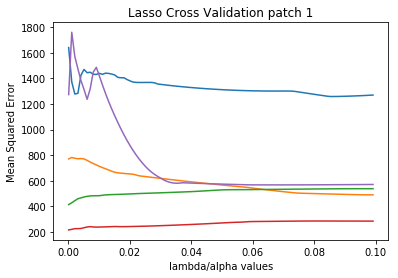

-----------------------------------------------------------------------------------------------------------
patch 2:
Lasso regression with lambda = 0.001
Lasso score: 0.946172
number of features used: 8
-----------------------------------
Lasso regression with lambda = 0.01
Lasso score: 0.929012
number of features used: 7
-----------------------------------
Lasso regression with lambda = 0.03
Lasso score: 0.912721
number of features used: 6
-----------------------------------
Lasso regression with lambda = 0.1
Lasso score: 0.887620
number of features used: 3
-----------------------------------


c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


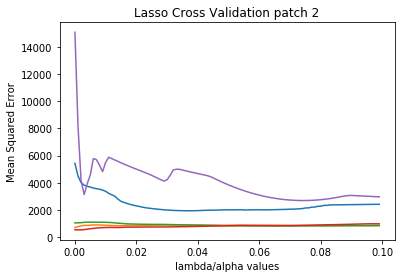

-----------------------------------------------------------------------------------------------------------
patch 3:
Lasso regression with lambda = 0.001


c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso score: 0.978753
number of features used: 8
-----------------------------------
Lasso regression with lambda = 0.01
Lasso score: 0.923673
number of features used: 5
-----------------------------------
Lasso regression with lambda = 0.03
Lasso score: 0.906050
number of features used: 2
-----------------------------------
Lasso regression with lambda = 0.1
Lasso score: 0.774229
number of features used: 2
-----------------------------------


c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


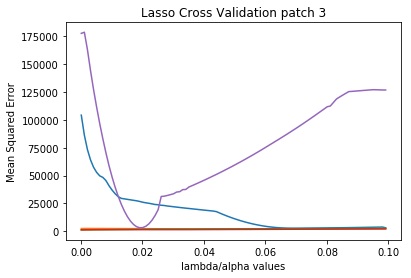

-----------------------------------------------------------------------------------------------------------
patch 4:
Lasso regression with lambda = 0.001


c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso score: 0.936146
number of features used: 11
-----------------------------------
Lasso regression with lambda = 0.01
Lasso score: 0.888207
number of features used: 8
-----------------------------------
Lasso regression with lambda = 0.03
Lasso score: 0.731298
number of features used: 5
-----------------------------------
Lasso regression with lambda = 0.1
Lasso score: 0.327580
number of features used: 1
-----------------------------------


c:\users\bruker\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


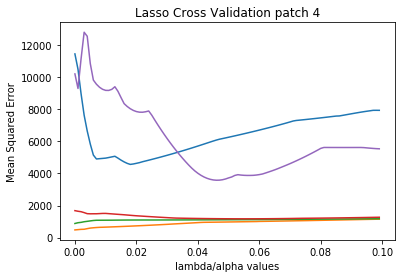

-----------------------------------------------------------------------------------------------------------


In [31]:
alphasLasso = arange(0.0001,0.1, 0.001)

print ("Lasso regression with Cross-validation")
print ("---------------------------------------")

i = 0
for i in range(0,num_patches):
    print("patch %d:" % (i+1))
    
    j = 0
    for j in range(0,size(lambLasso)):
        print ("Lasso regression with lambda =" , lambLasso[j])
        
        lasso = LassoCV(lambLasso[j], max_iter=iterations, cv = K).fit(Xmatrix[Vander_num-1], z_patch[i].ravel())

        print("Lasso score: %f" % lasso.score(Xmatrix[Vander_num-1], z_patch[i].ravel()))
        print("number of features used: %d" % sum(lasso.coef_ != 0))
        print("-----------------------------------")
    
    lasso_CV = LassoCV(alphas=alphasLasso, max_iter = iterations, cv = K).fit(Xmatrix[Vander_num-1], z_patch[i].ravel())
    plot(lasso_CV.alphas_, lasso_CV.mse_path_)
    xlabel("lambda/alpha values")
    ylabel("Mean Squared Error")
    title("Lasso Cross Validation patch %d" % (i+1))
    show()
    print("-----------------------------------------------------------------------------------------------------------")

